In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/kaggle/plant-pathology-2020-fgvc7.zip' -d '/content/drive/MyDrive/Colab Notebooks/kaggle/data'

In [4]:
import pandas as pd

In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/data/train.csv')
train.shape

(1821, 5)

In [6]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
train['healthy'].value_counts()

0    1305
1     516
Name: healthy, dtype: int64

In [12]:
# 데이터를 타겟별로 추출
healthy = len(train.loc[train['healthy']== 1])
multiple_diseases = len(train.loc[train['multiple_diseases']== 1])
rust = len(train.loc[train['rust']== 1])
scab = len(train.loc[train['scab']== 1])

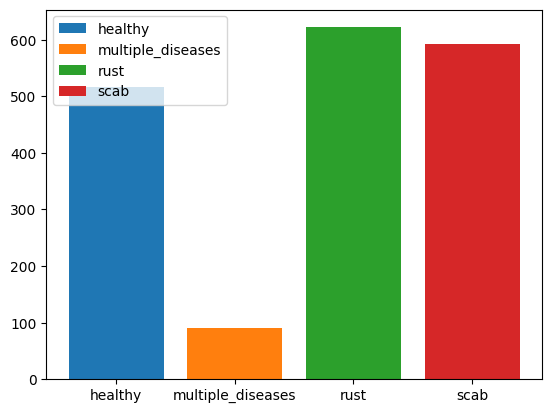

In [15]:
import matplotlib.pyplot as plt
plt.bar(['healthy'],healthy,label = 'healthy')
plt.bar(['multiple_diseases'],multiple_diseases, label='multiple_diseases')
plt.bar(['rust'],rust, label='rust')
plt.bar(['scab'],scab,label='scab')
plt.legend()
plt.show()

In [25]:
import numpy as np
lists = np.array([healthy, multiple_diseases,rust,scab])
total = lists.sum()
list(map(lambda x : round( x/total,3), lists))

[0.283, 0.05, 0.342, 0.325]

In [27]:
# 이미지 출력
from glob import glob
imagelists = glob('/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/*.jpg')
imagelists[:10]

['/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_10.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_100.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_1000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_1001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_1002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_1003.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_1004.jpg',
 '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Test_1005.jpg']

In [33]:
test = f'/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/{train["image_id"][2]}.jpg'
test

'/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/Train_2.jpg'

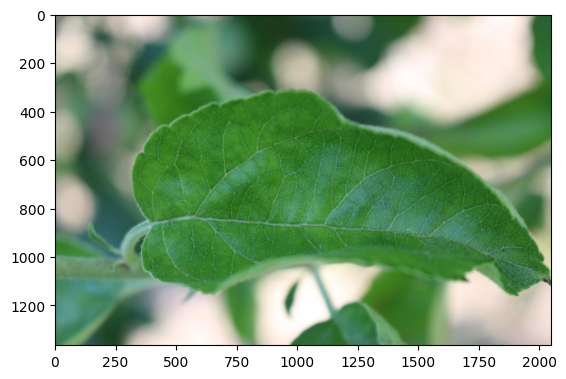

In [34]:
from PIL import Image
img = Image.open(test)
plt.imshow(img)

In [40]:
IMAGE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images'

In [39]:
train['imagepath'] = train['image_id'].apply(lambda x : IMAGE_FOLDER + x + '.jpg')
train.head()

,image_id,healthy,multiple_diseases,rust,scab,imagepath
0,Train_0,0,0,0,1,/content/drive/MyDrive/Colab Notebooks/kaggle/...
1,Train_1,0,1,0,0,/content/drive/MyDrive/Colab Notebooks/kaggle/...
2,Train_2,1,0,0,0,/content/drive/MyDrive/Colab Notebooks/kaggle/...
3,Train_3,0,0,1,0,/content/drive/MyDrive/Colab Notebooks/kaggle/...
4,Train_4,1,0,0,0,/content/drive/MyDrive/Colab Notebooks/kaggle/...


In [42]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/data/test.csv')
test.head()
# test['imagepath'] = test['image_id'].apply(lambda x : IMAGE_FOLDER + x + '.jpg')
# test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [65]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
# 데이터가 고르게 분포되도록 stratify 파라메터에 타깃값 4개를 전달
train, valid = train_test_split(train, 
                                test_size=0.1,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                                random_state=50)

In [66]:
train['healthy'].value_counts()

0    622
1    246
Name: healthy, dtype: int64

In [67]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일 경로
        image = cv2.imread(img_path)              # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        # 이미지 변환 
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환 
        if self.is_test:
            return image # 테스트용일 때
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스 
            label = np.argmax(self.df.iloc[idx, 1:5])  #가장 큰 값이 health 0.... 
            return image, label # 훈련/검증용일 때

In [68]:
# 이미지 변환을 위한 모듈
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [69]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절   (height, width)  원본이미지의 너비가 더 크므로 여기서도 이렇게 변경
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환 이동,확대/축소 회전등으로 이미지 모양을 전체적으로 바꾸는 변환
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환  transforms.ToTensor() 동일
])

In [70]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

In [71]:
img_dir = '/content/drive/MyDrive/Colab Notebooks/kaggle/data/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [72]:
import torch
import random
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [73]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [73]:
# 사전 훈련 모델 , 전이 학습
# 사전 훈련 모델: 어떤 분야의 훈련을 마친 모델
# 전이 학습 : 사전 훈련 모델을 유사한 다른 영역에서 재 훈련 시키는 기법
# 사전 훈련 모델
#    - torchvison.models -> 대다수가 선택하는 방법, 종류가많지 않다
#    - pretrainedmodels -> 카덴(테슬라 자율주행) github를 통해 제공 EfficientNet github pytorch 라고 검색
#    - 직접 구현한 모듈 -> 

In [74]:
# EfficientNet 모델 생성
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=dcd3d11cb612bca63705b9b02818f490db980c9abb6ee7d776deae0f6ba52bf4
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch


In [75]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

In [82]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) 
model = model.to(device) # 장비 할당

Loaded pretrained weights for efficientnet-b7


In [78]:
import torch.nn as nn

In [ ]:
# 사전 훈련된 efficientnet-b7 모델 불러오기 2번째 방법
model2 = EfficientNet.from_pretrained('efficientnet-b7')
#  (_fc): Linear(in_features=2560, out_features=1000, bias=True)
model2._fc = nn.Sequential(
    nn.Linear(model._fc.in_features, model._fc.out_features ),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(model._fc.out_features,4)
)

In [83]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()

In [84]:
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu().numpy()].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

In [91]:
torch.eye(4)[0]

tensor([1., 0., 0., 0.])

In [ ]:
# 성능 개선
# 1. 손실함수와 옵티마이져 설정
# 2. 모델 훈련과 검증 : 스케줄러 설정(에폭증가) --> 개선사항
# 3. 훈련 및 성능 개선

# 예측
# 1.TTA(테스트단계 데이터 증강) ->개선사항
# 2. 예측
# 3. 레이블 스무딩 --> 개선사항


In [97]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
# 지정한 값만큼 학습률을 증가시켰다가 코사인 그래프 모양으로 점차 감소시키는 스케줄러
from transformers import get_cosine_schedule_with_warmup
# epochs = 39
epochs = 1   # 시간이 오래걸려서 돌아가는 것만 확인하기위햇 2로 설정... 실제로는 20~50사이를 추천

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(loader_train)*3, # 몇번만에 지정한 학습률에 도달할 지를 결정... 
    num_training_steps=len(loader_train)*epochs  # 모든 훈련을 마치는 데 필요한 반복 횟수
)

In [102]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
        scheduler.step() # 스케줄러 학습률 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu().numpy()].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/217 [00:00<?, ?it/s]

에폭 [1/1] - 훈련 데이터 손실값 : 0.2418
에폭 [1/1] - 검증 데이터 손실값 : 0.1116 / 검증 데이터 ROC AUC : 0.9979


In [103]:
# TTA(테스트 단계 데이터 증강)
# 학습이 아니라... 테스트 단계에서 활용하는 기법 Test Time Augmentation

# 절차
# 테스트 데이터에 여러번 변환을 적용
# 변환된 테스트데이터별로 타깃 확률값을 예측
# 평균을 구한다.
#---> 보팅....과 비슷

In [ ]:
# --- 데이터셋 다시 구성..